In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("Preprocessed ICU data.csv")

df.head()


,RecordID,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,...,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death
0,132543,68,1.0,180.300000,0,1,0,84.600000,14.888889,72.971429,...,12.000000,15.000000,0.200000,2.395461,156.842105,7.132683,1.114629,7,1,0
1,132545,88,0.0,169.787227,0,1,0,83.054136,15.000000,79.520000,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,17,2,0
2,132547,64,1.0,180.300000,0,0,0,114.000000,8.333333,81.318182,...,60.000000,162.000000,0.400000,2.395461,212.000000,1.300000,1.114629,14,11,0
3,132551,78,0.0,162.600000,0,1,0,48.400000,13.250000,78.125000,...,46.000000,82.000000,0.300000,2.300000,156.842105,3.500000,1.114629,19,8,1
4,132554,64,0.0,169.787227,0,1,0,60.700000,15.000000,129.363636,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,11,0,0


<Axes: xlabel='Age', ylabel='Height'>

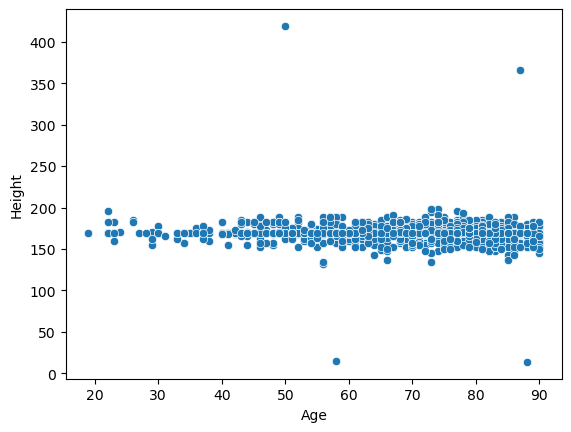

In [3]:
sns.scatterplot(x="Age", y = "Height", data=df)



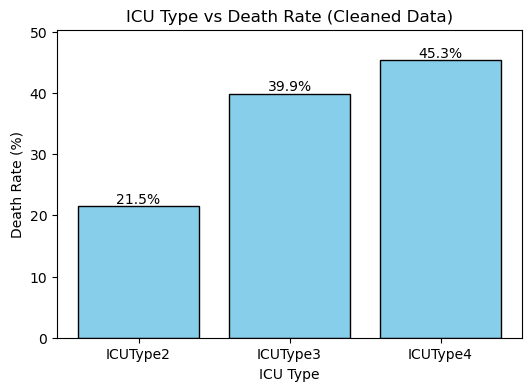

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "Preprocessed ICU data.csv" 
df = pd.read_csv(file_path)

icu_df = df[['ICUType2', 'ICUType3', 'ICUType4', 'In.hospital_death']].copy()

icu_df = icu_df[~((icu_df['ICUType2'] == 0) & 
                  (icu_df['ICUType3'] == 0) & 
                  (icu_df['ICUType4'] == 0))]

def get_icu_type(row):
    if row['ICUType2'] == 1:
        return "ICUType2"
    elif row['ICUType3'] == 1:
        return "ICUType3"
    elif row['ICUType4'] == 1:
        return "ICUType4"

icu_df['ICUType'] = icu_df.apply(get_icu_type, axis=1)

icu_df.drop(columns=['ICUType2', 'ICUType3', 'ICUType4'], inplace=True)

death_rate = icu_df.groupby('ICUType')['In.hospital_death'].mean().reset_index()
death_rate['In.hospital_death'] *= 100

plt.figure(figsize=(6,4))
plt.bar(death_rate['ICUType'], death_rate['In.hospital_death'], 
        color='skyblue', edgecolor='black')
plt.ylabel('Death Rate (%)')
plt.xlabel('ICU Type')
plt.title('ICU Type vs Death Rate (Cleaned Data)')
plt.ylim(0, death_rate['In.hospital_death'].max() + 5)

for i, rate in enumerate(death_rate['In.hospital_death']):
    plt.text(i, rate + 0.5, f"{rate:.1f}%", ha='center')

plt.show()


Dropping constant/zero-variance columns: ['Mean_MechVent.x', 'Min_MechVent.x', 'Max_MechVent.x', 'Mean_MechVent.y', 'Min_MechVent.y', 'Max_MechVent.y']
=== Output files ===
top30_correlated_pairs.csv
highly_correlated_pairs_ge_0.90.csv
suggested_drops.csv
summary_pruning.csv
corr_with_target.csv


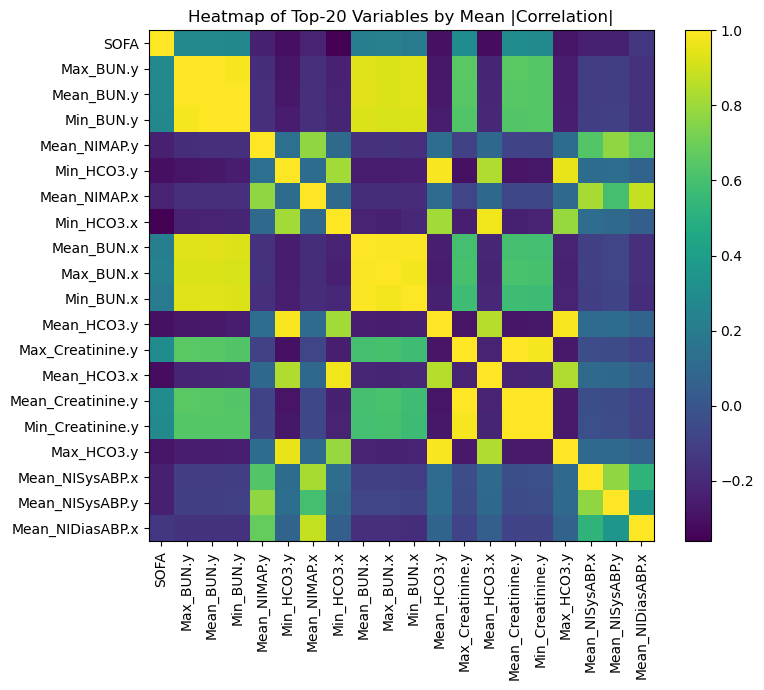

In [6]:
# correlation_pruning_robust.py
# Usage: put this script together with "Preprocessed ICU data.csv" and run directly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# ========= Config =========
CSV_PATH = "Preprocessed ICU data.csv"
HIGH_R_TH = 0.90          # threshold for “too high correlation”: |r| >= 0.90
TOPK_HEATMAP = 20         # number of variables in heatmap (by mean |corr|)
DROP_RECORDID = True      # drop RecordID if present
TARGET_COL = "In.hospital_death"  # target column (reference only)

# ========= Utils =========
def base_name(name: str) -> str:
    return name[:-2] if name.endswith(".x") or name.endswith(".y") else name

def pick_drop(a: str, b: str, miss: pd.Series) -> Tuple[str, str]:
    """
    Return (drop_col, keep_col) recommendation.
    Rules:
      1) Mean vs (Min/Max): keep Mean
      2) Same root (.x/.y): keep fewer-missing; if tie, keep .x
      3) Otherwise: keep fewer-missing; if tie, keep lexicographically smaller
    """
    a_miss, b_miss = miss.get(a, 1.0), miss.get(b, 1.0)
    al, bl = a.lower(), b.lower()
    is_mean = lambda s: "mean_" in s
    is_min  = lambda s: "min_"  in s
    is_max  = lambda s: "max_"  in s

    # 1) Mean vs (Min/Max)
    if is_mean(al) and (is_min(bl) or is_max(bl)):  # keep a
        return b, a
    if is_mean(bl) and (is_min(al) or is_max(al)):  # keep b
        return a, b

    # 2) Same root (.x/.y)
    if base_name(a) == base_name(b):
        if a_miss < b_miss:
            return b, a
        elif b_miss < a_miss:
            return a, b
        else:
            if a.endswith(".x") and b.endswith(".y"):
                return b, a
            if b.endswith(".x") and a.endswith(".y"):
                return a, b

    # 3) Otherwise
    if a_miss < b_miss:
        return b, a
    elif b_miss < a_miss:
        return a, b
    else:
        return (b, a) if a < b else (a, b)

# ========= Load & prepare =========
df = pd.read_csv(CSV_PATH)
num_df = df.select_dtypes(include=[np.number]).copy()

if DROP_RECORDID and "RecordID" in num_df.columns:
    num_df.drop(columns=["RecordID"], inplace=True)

# --- NEW: drop constant / zero-variance / all-NaN columns to avoid divide-by-zero in corr ---
const_cols = []
for c in list(num_df.columns):
    col = num_df[c]
    if col.isna().all():
        const_cols.append(c)                   # all NaN
    elif col.nunique(dropna=True) <= 1:
        const_cols.append(c)                   # constant value
    elif np.isclose(col.std(ddof=0), 0.0, atol=1e-12):
        const_cols.append(c)                   # zero variance (safety)

if const_cols:
    print("Dropping constant/zero-variance columns:", const_cols)
    num_df.drop(columns=const_cols, inplace=True)

# Split target (reference only)
y = None
if TARGET_COL in num_df.columns:
    y = num_df[TARGET_COL]
    X = num_df.drop(columns=[TARGET_COL])
else:
    X = num_df

assert X.shape[1] > 1, f"No numeric features available after filtering; X.shape={X.shape}"

# ========= Missing rate =========
missing_rate = X.isna().mean().rename("missing_rate")

# ========= Pearson correlation (feature-feature) =========
corr_mat = X.corr(method="pearson")

# Flatten upper triangle into pairs
pairs = []
cols = corr_mat.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr_mat.iloc[i, j]
        if pd.notna(r):
            pairs.append((cols[i], cols[j], r, abs(r), r**2))
pairs_df = pd.DataFrame(pairs, columns=["var1","var2","r","abs_r","r2"]).sort_values("abs_r", ascending=False)

# ========= Highly correlated pairs (|r| >= threshold) =========
high_pairs = pairs_df[pairs_df["abs_r"] >= HIGH_R_TH].reset_index(drop=True)

# ========= Suggested drops (rule-based) =========
to_drop, to_keep = set(), set(X.columns.tolist())
for _, row in high_pairs.iterrows():
    a, b = row["var1"], row["var2"]
    if a in to_keep and b in to_keep:
        drop_col, keep_col = pick_drop(a, b, missing_rate)
        if drop_col in to_keep:
            to_keep.remove(drop_col)
            to_drop.add(drop_col)

# ========= Correlation with target (reference only) =========
target_corr = None
if y is not None:
    target_corr = X.apply(lambda c: c.corr(y)).to_frame(name="r_with_target")
    target_corr["abs_r"] = target_corr["r_with_target"].abs()
    target_corr.sort_values("abs_r", ascending=False, inplace=True)

# ========= Export =========
pairs_df.head(30).to_csv("top30_correlated_pairs.csv", index=False)
high_pairs[["var1","var2","r","r2"]].to_csv(f"highly_correlated_pairs_ge_{HIGH_R_TH:.2f}.csv", index=False)
pd.DataFrame(sorted(to_drop), columns=["suggest_drop"]).assign(
    missing_rate=lambda d: d["suggest_drop"].map(missing_rate)
).to_csv("suggested_drops.csv", index=False)
pd.DataFrame({
    "n_features_total":[X.shape[1]],
    f"n_pairs_|r|>={HIGH_R_TH:.2f}":[high_pairs.shape[0]],
    "n_drop_suggested":[len(to_drop)],
    "n_keep_expected":[len(to_keep)]
}).to_csv("summary_pruning.csv", index=False)
if target_corr is not None:
    target_corr.to_csv("corr_with_target.csv")

print("=== Output files ===")
print("top30_correlated_pairs.csv")
print(f"highly_correlated_pairs_ge_{HIGH_R_TH:.2f}.csv")
print("suggested_drops.csv")
print("summary_pruning.csv")
if target_corr is not None:
    print("corr_with_target.csv")

# ========= Visualization: heatmap of top-K by mean |corr| =========
mean_abs_corr = corr_mat.abs().replace(1.0, np.nan).mean().sort_values(ascending=False)
top_vars = mean_abs_corr.head(min(TOPK_HEATMAP, len(mean_abs_corr))).index.tolist()
sub_corr = corr_mat.loc[top_vars, top_vars]

plt.figure(figsize=(8,7))
plt.imshow(sub_corr, aspect='auto')  # default colormap, no custom styles
plt.colorbar()
plt.xticks(range(len(top_vars)), top_vars, rotation=90)
plt.yticks(range(len(top_vars)), top_vars)
plt.title(f"Heatmap of Top-{len(top_vars)} Variables by Mean |Correlation|")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load dataset
df = pd.read_csv("Preprocessed ICU data.csv")

# Drop ID columns
if "RecordID" in df.columns:
    df = df.drop(columns=["RecordID"])

# Target and features
y = df["In.hospital_death"]
X = df.drop(columns=["In.hospital_death"])

# Handle missing values (simple fill)
X = X.fillna(X.median())

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


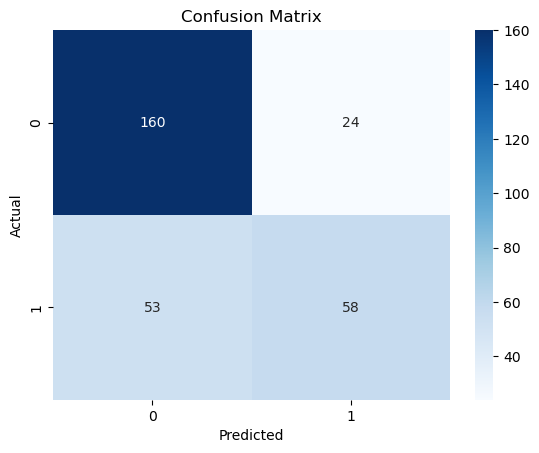

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       184
           1       0.71      0.52      0.60       111

    accuracy                           0.74       295
   macro avg       0.73      0.70      0.70       295
weighted avg       0.73      0.74      0.73       295



In [7]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


In [9]:
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_imp.head(20))  # top 20


            feature  importance
118      Mean_GCS.y    0.032869
192       Max_GCS.y    0.029661
155       Min_GCS.y    0.020055
193        Max_HR.y    0.011872
7        Mean_GCS.x    0.011769
119       Mean_HR.y    0.010977
125    Mean_Urine.y    0.009250
202   Max_Glucose.y    0.008316
8         Mean_HR.x    0.008038
209       Max_WBC.y    0.007997
81        Max_GCS.x    0.007917
45         Min_HR.x    0.007832
143   Mean_SysABP.y    0.007339
187   Min_Lactate.y    0.007272
135      Mean_WBC.y    0.007209
32    Mean_SysABP.x    0.007208
199     Max_Urine.y    0.007138
82         Max_HR.x    0.007086
150  Mean_Lactate.y    0.006852
124     Mean_Temp.y    0.006847


In [11]:
all_rankings = []
for seed in [0, 21, 42, 100, 123]:
    model = RandomForestClassifier(n_estimators=200, random_state=seed)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    all_rankings.append(
        pd.Series(importances, index=X.columns).sort_values(ascending=False).head(10).index.tolist()
    )

print(all_rankings)


[['Mean_GCS.y', 'Max_GCS.y', 'Min_GCS.y', 'Mean_GCS.x', 'Mean_HR.y', 'Max_GCS.x', 'Max_HR.y', 'Mean_HR.x', 'Max_Glucose.y', 'Max_HR.x'], ['Mean_GCS.y', 'Min_GCS.y', 'Max_GCS.y', 'Mean_GCS.x', 'Max_GCS.x', 'Mean_HR.y', 'Mean_HR.x', 'Max_HR.y', 'Max_HR.x', 'Mean_WBC.y'], ['Mean_GCS.y', 'Max_GCS.y', 'Min_GCS.y', 'Max_HR.y', 'Mean_GCS.x', 'Mean_HR.y', 'Mean_Urine.y', 'Max_Glucose.y', 'Mean_HR.x', 'Max_WBC.y'], ['Mean_GCS.y', 'Max_GCS.y', 'Min_GCS.y', 'Mean_GCS.x', 'Max_GCS.x', 'Mean_HR.y', 'Max_Urine.y', 'Mean_SysABP.y', 'Mean_Urine.y', 'Max_HR.y'], ['Mean_GCS.y', 'Min_GCS.y', 'Max_GCS.y', 'Mean_GCS.x', 'Max_GCS.x', 'Mean_HR.y', 'Mean_HR.x', 'Mean_Urine.y', 'Max_HR.y', 'Mean_SysABP.y']]


In [1]:
# Cell 1 — Imports
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [3]:
# Cell 2 — Load data (no Time filtering)
CSV_PATH = "Preprocessed ICU data.csv"  # adjust if needed

df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()  # tidy column names

# Drop pure identifier if present
if "RecordID" in df.columns:
    df = df.drop(columns=["RecordID"])

# Ensure target exists
TARGET = "In.hospital_death"
assert TARGET in df.columns, f"Target column '{TARGET}' not found. Available columns: {list(df.columns)[:10]} ..."


In [5]:
# Cell 3 — Requested base variables (as per instructions)
# We'll auto-pick the best measurement (Mean_/Min_/Max_ and .x/.y) for each.
BASE_VARS = [
    "GCS", "HR", "Platelets", "Urine", "WBC", "BUN", "Temp",
    "Glucose", "PaO2", "PaCO2", "SysABP", "HCO3", "Weight", "Lactate"
]


In [7]:
# Cell 4 — Utilities to find candidate columns for each base variable

def normalized_base(colname: str) -> str:
    """
    Strip 'Mean_/Min_/Max_' prefixes and '.x/.y' suffixes to get the base.
    E.g. 'Mean_GCS.x' -> 'GCS'; 'Max_Lactate.y' -> 'Lactate'
    """
    name = colname
    for pref in ("Mean_", "Min_", "Max_"):
        if name.startswith(pref):
            name = name[len(pref):]
            break
    if "." in name:
        name = name.split(".", 1)[0]
    return name

def find_candidates_for(base: str, all_cols: List[str]) -> List[str]:
    """
    Return numeric columns whose normalized base equals the requested base variable.
    Prioritize standard ICU naming patterns.
    """
    # numeric-only columns
    numeric_cols = [c for c in all_cols if pd.api.types.is_numeric_dtype(df[c])]
    # candidates whose normalized base equals e.g. 'GCS'
    candidates = [c for c in numeric_cols if normalized_base(c).lower() == base.lower()]
    # If the raw base exists as-is (rare), include it too
    if base in df.columns and base not in candidates and pd.api.types.is_numeric_dtype(df[base]):
        candidates.append(base)
    return candidates


In [9]:
# Cell 5 — Pick "best measurement" per base var via univariate standardized logistic regression
# We standardize each candidate feature (fit on train only) and compare absolute coefficient sizes.

RANDOM_STATE = 42

def pick_best_measurement(base: str, y: pd.Series) -> Tuple[str, float]:
    """
    For a given base variable (e.g., 'GCS'), among its candidate columns
    (Mean_/Min_/Max_ and .x/.y), fit univariate standardized logistic regression
    and pick the one with the largest |coef|.
    Returns (best_column_name, best_abs_coef). If none, returns (None, np.nan).
    """
    candidates = find_candidates_for(base, df.columns.tolist())
    if not candidates:
        return None, np.nan

    # Train/test split indices (stratified to preserve class balance)
    idx = df.index
    y_full = df[TARGET]
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full)

    best_col, best_abs_coef = None, -np.inf
    for c in candidates:
        # Build train/test series
        x_train = df.loc[train_idx, c].astype(float)
        x_test  = df.loc[test_idx,  c].astype(float)
        y_train = y_full.loc[train_idx]
        # Impute with train median
        med = x_train.median()
        x_train = x_train.fillna(med).to_frame()
        x_test  = x_test.fillna(med).to_frame()
        # Standardize + Logistic Regression
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ])
        pipe.fit(x_train, y_train)
        # Extract coef for the single feature
        coef = pipe.named_steps["lr"].coef_[0][0]
        if abs(coef) > best_abs_coef:
            best_abs_coef = abs(coef)
            best_col = c

    return best_col, best_abs_coef

selected_map: Dict[str, str] = {}
scores_map: Dict[str, float] = {}

for base in BASE_VARS:
    best_col, score = pick_best_measurement(base, df[TARGET])
    selected_map[base] = best_col
    scores_map[base] = score

print("Best measurement per base variable:")
for k, v in selected_map.items():
    print(f" - {k:10s} -> {v}")


Best measurement per base variable:
 - GCS        -> Mean_GCS.y
 - HR         -> Mean_HR.x
 - Platelets  -> Min_Platelets.y
 - Urine      -> Mean_Urine.y
 - WBC        -> Max_WBC.y
 - BUN        -> Max_BUN.y
 - Temp       -> Max_Temp.x
 - Glucose    -> Max_Glucose.y
 - PaO2       -> Max_PaO2.x
 - PaCO2      -> Min_PaCO2.y
 - SysABP     -> Min_SysABP.y
 - HCO3       -> Min_HCO3.y
 - Weight     -> Max_Weight.y
 - Lactate    -> Mean_Lactate.y


In [11]:
# Cell 6 — Build the modeling table with the chosen columns (one per base var)
chosen_cols = [c for c in selected_map.values() if c is not None]
missing_bases = [b for b, c in selected_map.items() if c is None]

print("\nChosen feature columns:", chosen_cols)
if missing_bases:
    print("WARNING — No matching columns found for these bases, they will be skipped:", missing_bases)

assert len(chosen_cols) > 0, "No usable features were found. Check column names in the CSV."

X_full = df[chosen_cols].copy()
y_full = df[TARGET].astype(int).copy()

# Simple median imputation (fit on train only later)



Chosen feature columns: ['Mean_GCS.y', 'Mean_HR.x', 'Min_Platelets.y', 'Mean_Urine.y', 'Max_WBC.y', 'Max_BUN.y', 'Max_Temp.x', 'Max_Glucose.y', 'Max_PaO2.x', 'Min_PaCO2.y', 'Min_SysABP.y', 'Min_HCO3.y', 'Max_Weight.y', 'Mean_Lactate.y']


In [13]:
# Cell 7 — Train/test split and full multivariate Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full
)

# Median impute using train medians
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

# Standardize + Logistic Regression
full_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])
full_pipe.fit(X_train, y_train)

y_pred = full_pipe.predict(X_test)

print("=== Confusion Matrix (All chosen features) ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== Classification Report (All chosen features) ===")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy (All chosen features):", accuracy_score(y_test, y_pred))


=== Confusion Matrix (All chosen features) ===
[[158  26]
 [ 57  54]]

=== Classification Report (All chosen features) ===
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       184
           1       0.68      0.49      0.57       111

    accuracy                           0.72       295
   macro avg       0.70      0.67      0.68       295
weighted avg       0.71      0.72      0.71       295

Accuracy (All chosen features): 0.7186440677966102


In [15]:
# Cell 8 — Coefficients (sorted by absolute value)
# Extract standardized coefficients
lr = full_pipe.named_steps["lr"]
scaler = full_pipe.named_steps["scaler"]

coefs = pd.Series(lr.coef_[0], index=X_train.columns)
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": coefs.values,
    "abs_coef": np.abs(coefs.values)
}).sort_values("abs_coef", ascending=False).reset_index(drop=True)

print("=== Coefficients (standardized), sorted by |coef| ===")
display(coef_df)


=== Coefficients (standardized), sorted by |coef| ===


,feature,coef,abs_coef
0,Mean_GCS.y,-0.839722,0.839722
1,Mean_HR.x,0.236273,0.236273
2,Max_PaO2.x,-0.233449,0.233449
3,Max_Weight.y,-0.179269,0.179269
4,Mean_Lactate.y,0.178844,0.178844
5,Max_WBC.y,0.155662,0.155662
6,Min_HCO3.y,-0.139499,0.139499
7,Max_BUN.y,0.123535,0.123535
8,Max_Temp.x,-0.105005,0.105005
9,Max_Glucose.y,0.089902,0.089902


In [17]:
# Cell 9 — Top-10 and Top-5 feature sets, retrain & evaluate

def train_eval_with_features(feature_list: List[str]) -> Tuple[float, pd.DataFrame, str]:
    Xtr = X_train[feature_list].copy()
    Xte = X_test[feature_list].copy()
    # Refit a fresh pipeline (avoid data leakage)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
    ])
    pipe.fit(Xtr, y_train)
    pred = pipe.predict(Xte)
    acc = accuracy_score(y_test, pred)
    cm  = confusion_matrix(y_test, pred)
    rep = classification_report(y_test, pred, zero_division=0)
    return acc, pd.DataFrame(cm, index=["Actual_0","Actual_1"], columns=["Pred_0","Pred_1"]), rep

# Top-10
top10 = coef_df.head(min(10, len(coef_df)))["feature"].tolist()
acc10, cm10, rep10 = train_eval_with_features(top10)
print("\n=== TOP-10 FEATURES ===")
print("Features:", top10)
print("Accuracy:", acc10)
print("\nConfusion Matrix:\n", cm10)
print("\nClassification Report:\n", rep10)

# Top-5
top5 = coef_df.head(min(5, len(coef_df)))["feature"].tolist()
acc5, cm5, rep5 = train_eval_with_features(top5)
print("\n=== TOP-5 FEATURES ===")
print("Features:", top5)
print("Accuracy:", acc5)
print("\nConfusion Matrix:\n", cm5)
print("\nClassification Report:\n", rep5)



=== TOP-10 FEATURES ===
Features: ['Mean_GCS.y', 'Mean_HR.x', 'Max_PaO2.x', 'Max_Weight.y', 'Mean_Lactate.y', 'Max_WBC.y', 'Min_HCO3.y', 'Max_BUN.y', 'Max_Temp.x', 'Max_Glucose.y']
Accuracy: 0.7050847457627119

Confusion Matrix:
           Pred_0  Pred_1
Actual_0     157      27
Actual_1      60      51

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       184
           1       0.65      0.46      0.54       111

    accuracy                           0.71       295
   macro avg       0.69      0.66      0.66       295
weighted avg       0.70      0.71      0.69       295


=== TOP-5 FEATURES ===
Features: ['Mean_GCS.y', 'Mean_HR.x', 'Max_PaO2.x', 'Max_Weight.y', 'Mean_Lactate.y']
Accuracy: 0.6949152542372882

Confusion Matrix:
           Pred_0  Pred_1
Actual_0     155      29
Actual_1      61      50

Classification Report:
               precision    recall  f1-score   support

           0       0.72     

In [19]:
# Cell 10 — Summary table of accuracies
summary = pd.DataFrame({
    "feature_set": ["All chosen (1 per base)", "Top-10 by |coef|", "Top-5 by |coef|"],
    "accuracy": [
        accuracy_score(y_test, full_pipe.predict(X_test)),
        acc10,
        acc5
    ]
})
summary


,feature_set,accuracy
0,All chosen (1 per base),0.718644
1,Top-10 by |coef|,0.705085
2,Top-5 by |coef|,0.694915
